## Implementing Naive Bayes Model using n-grams for Author Classification 

In [ ]:
# imports
import pandas as pd
import numpy as np
from nltk import ngrams
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from nltk import FreqDist
from sklearn.metrics import accuracy_score

### Reading the balanced dataset created in file 'balancing_dataset.ipynb'

In [3]:
# read file balanced dataset (approx 15K per pole)
tokenized_nationality_balanced = pd.read_csv("data/Undersampled_balanced_data.csv")
tokenized_nationality_balanced.head(10)

,auhtor_ID,post,nationality,Poles,tokens,eng_tokens,average_word_length,avg_sentence_length,ttr,ner,norm_.,"norm_,",norm_?,norm_!,topic_distributions,nr_unique_words,nr_chars,nr_contradictions,subjectivity
0,t2_ffcfiueh,course people look hyperbolic one racism bad e...,Norway,Western,"['[""[\'course\',"",', '""\'people\',"",', '""\'loo...","[""'course'"", ""'people'"", ""'look'"", ""'hyperboli...",5.481442,66.164835,0.707317,"[('one', 'CARDINAL'), ('bkb', 'ORG'), ('hundre...",0.091198,0.047720,0.006363,0.007423,"[(6, 0.27886572), (10, 0.17313653), (25, 0.319...",667,6111,6,0.485495
1,t2_lfs48,police drag foot it/come different conclusion ...,Germany,Western,"['[""[\'police\',"",', '""\'drag\',"",', '""\'foot\...","[""'police'"", ""'drag'"", ""'foot'"", ""'it'"", ""'com...",6.285714,85.014925,0.718078,"[('anmeldung', 'GPE'), ('berlin', 'GPE'), ('fi...",0.113780,0.078382,0.002528,0.000000,"[(25, 0.72906566), (27, 0.26771897)]",568,5762,17,0.487030
2,t2_zcj4y,nice curves. really pretty. maybe i'm 'oldscho...,The Netherlands,Western,"['[""[\'nice\',"",', '""\'curves\',"",', '""\'.\',""...","[""'nice'"", ""'really'"", ""'pretty'"", ""'maybe'"", ...",5.580460,34.134969,0.747126,"[('lootboxes', 'NORP'), ('1', 'CARDINAL'), (""1...",0.174713,0.065517,0.021839,0.010345,"[(5, 0.067286186), (10, 0.1327022), (25, 0.799...",650,5724,18,0.551005
3,t2_2xpu7n1c,action try manufacture result make “good” tv. ...,United Kingdom,Western,"['[""[\'action\',"",', '""\'try\',"",', '""\'manufa...","[""'action'"", ""'try'"", ""'manufacture'"", ""'resul...",5.481297,75.441176,0.640898,"[('lewis', 'PERSON'), ('max', 'PERSON'), ('max...",0.073566,0.112219,0.009975,0.002494,"[(10, 0.286261), (25, 0.7099816)]",514,5197,0,0.514366
4,t2_3edl7,"location, altitude, speed, direction every dji...",Germany,Western,"['[""[\'location\',"",', '""\',\',"",', '""\'altitu...","[""'location'"", ""'altitude'"", ""'speed'"", ""'dire...",5.916865,60.968085,0.719715,"[('dji', 'PRODUCT'), ('30 miles', 'QUANTITY'),...",0.122328,0.085511,0.005938,0.001188,"[(3, 0.019032711), (25, 0.04007173), (27, 0.93...",606,5823,11,0.401854
5,t2_r4dta,far iptv. lot trial error finally found config...,Germany,Western,"['[""[\'far\',"",', '""\'iptv\',"",', '""\'.\',"",',...","[""'far'"", ""'lot'"", ""'trial'"", ""'error'"", ""'fin...",5.458732,83.477273,0.651607,"[('around 95%', 'PERCENT'), ('two', 'CARDINAL'...",0.083406,0.046047,0.006950,0.004344,"[(3, 0.68141955), (25, 0.28099504), (27, 0.036...",750,7433,10,0.505461
6,t2_8oq1onsp,19th century? i'm first come criticising germa...,Germany,Western,"['[""[\'19th\',"",', '""\'century\',"",', '""\'?\',...","[""'th'"", ""'century'"", ""'i'"", ""'m'"", ""'first'"",...",6.331250,54.857143,0.732500,"[('19th century', 'DATE'), ('first', 'ORDINAL'...",0.117500,0.068750,0.017500,0.000000,"[(10, 0.19710149), (25, 0.014830774), (27, 0.7...",586,5864,11,0.463771
7,t2_ohefx,read theory. i'm sure learn difference univers...,Denmark,Western,"['[""[\'read\',"",', '""\'theory\',"",', '""\'.\',""...","[""'read'"", ""'theory'"", ""'i'"", ""'m'"", ""'sure'"",...",4.929730,66.163265,0.589189,"[('america', 'GPE'), ('europe', 'LOC'), ('amer...",0.098198,0.042342,0.010811,0.000000,"[(6, 0.6443614), (10, 0.17756967), (25, 0.0357...",654,6581,9,0.473738
8,t2_kd2lsk,i'd say probably - maybe racist - bias. can't ...,France,Western,"['[""[\'i\',"",', '\'""\\\'d"",\',', '""\'say\',"",'...","[""'i'"", ""'d'"", ""'say'"", ""'probably'"", ""'maybe'...",5.734149,107.107143,0.751947,"[('french', 'NORP'), ('5 year', 'DATE'), ('aus...",0.055617,0.094549,0.008899,0.004449,"[(10, 0.23158021), (16, 0.11595541), (25, 0.60...",676,6053,24,0.497906
9,t2_y77lc,another. ai text recognition also better human...,Finland,Western,"['[""[\'another\',"",', '""\'.\',"",', '""\'ai\',"",...","[""'another'"", ""'ai'"", ""'text'"", ""'recognition'...",5.554726,55.666667,0.671642,"[('one', 'CARDINAL'), ('first', 'ORDINAL'), ('...",0.113184,0.078358,0.002488,0.000000,"[(25, 0.9238123), (27, 0.06894950

#### Creating column of bi-grams

In [4]:
# Function to create bi-grams from a list of tokens
def generate_bi_grams(tokens):
    return list(ngrams(tokens, 2))

# Apply the bi-gram extraction to the 'eng_tokens' column
tokenized_nationality_balanced['bi_grams'] = tokenized_nationality_balanced['eng_tokens'].apply(lambda x: generate_bi_grams(literal_eval(x)))

# Display the resulting DataFrame
print(tokenized_nationality_balanced[['Poles', 'eng_tokens', 'bi_grams']])

         Poles                                         eng_tokens  \
0      Western  ["'course'", "'people'", "'look'", "'hyperboli...   
1      Western  ["'police'", "'drag'", "'foot'", "'it'", "'com...   
2      Western  ["'nice'", "'really'", "'pretty'", "'maybe'", ...   
3      Western  ["'action'", "'try'", "'manufacture'", "'resul...   
4      Western  ["'location'", "'altitude'", "'speed'", "'dire...   
...        ...                                                ...   
30937  Eastern  ["'raid'", "'good'", "'hunt'", "'mean'", "'gov...   
30938  Eastern  ["'homemade'", "'one'", "'kill'", "'people'", ...   
30939  Eastern  ["'head'", "'look'", "'like'", "'imperialism'"...   
30940  Eastern  ["'purgatory'", "'help'", "'soul'", "'get'", "...   
30941  Eastern  ["'claim'", "'talking'", "'ca'", "'even'", "'e...   

                                                bi_grams  
0      [('course', 'people'), ('people', 'look'), ('l...  
1      [('police', 'drag'), ('drag', 'foot'), ('foot'

### Frequency distribution for bi-grams column:

In [5]:
# Extract bigrams from the 'bi_grams' column and store in all_bigrams_balanced
all_bigrams_balanced = [bigram for sublist in tokenized_nationality_balanced['bi_grams'] for bigram in sublist]

# Calculate the frequency distribution of bigrams
bigram_freq_dist_balanced = FreqDist(all_bigrams_balanced)

# Display a subset of bigrams and their frequencies
print("\nBigram Frequency Distribution for tokenized_nationality_balanced (Top 30):")
print(bigram_freq_dist_balanced.most_common(30))  # Displaying the top 30 bigrams


Bigram Frequency Distribution for tokenized_nationality_balanced (Top 30):
[(("'i'", "'m'"), 93275), (("'n'", "'t'"), 90366), (("'that'", "'s'"), 76212), (("'ca'", "'n'"), 38775), (("'it'", "'s'"), 27552), (("'there'", "'s'"), 26681), (("'they'", "'re'"), 24016), (("'i'", "'d'"), 21070), (("'do'", "'n'"), 19119), (("'he'", "'s'"), 17795), (("'look'", "'like'"), 10871), (("'de'", "'de'"), 10118), (("'what'", "'s'"), 10055), (("'we'", "'re'"), 9407), (("'gon'", "'na'"), 8859), (("'de'", "'la'"), 8011), (("'feel'", "'like'"), 7868), (("'x'", "'b'"), 7601), (("'year'", "'ago'"), 7375), (("'m'", "'sure'"), 7369), (("'make'", "'sense'"), 7176), (("'can'", "'not'"), 7108), (("'let'", "'s'"), 6857), (("'does'", "'n'"), 6507), (("'you'", "'re'"), 6488), (("'pretty'", "'much'"), 6339), (("'sound'", "'like'"), 6330), (("'did'", "'n'"), 5925), (("'like'", "'that'"), 5775), (("'da'", "'se'"), 5648)]


### Compare the frequency of the top 30 bi-grams for eastern and western 

In [6]:
# Create separate datasets for Eastern and Western poles
eastern_data_balanced = tokenized_nationality_balanced[tokenized_nationality_balanced['Poles'] == 'Eastern']
western_data_balanced = tokenized_nationality_balanced[tokenized_nationality_balanced['Poles'] == 'Western']

# Extract bigrams for Eastern poles
eastern_bigrams_balanced = [bigram for sublist in eastern_data_balanced['bi_grams'] for bigram in sublist]
eastern_bigram_freq_dist_balanced = FreqDist(eastern_bigrams_balanced)

# Extract bigrams for Western poles
western_bigrams_balanced = [bigram for sublist in western_data_balanced['bi_grams'] for bigram in sublist]
western_bigram_freq_dist_balanced = FreqDist(western_bigrams_balanced)

# Get the top 30 bigrams for each pole
top30_eastern_bigrams_balanced = eastern_bigram_freq_dist_balanced.most_common(30)
top30_western_bigrams_balanced = western_bigram_freq_dist_balanced.most_common(30)

# Convert bigram tuples to strings
top30_eastern_bigrams_balanced_str = [f"{bigram[0]} {bigram[1]}" for bigram, _ in top30_eastern_bigrams_balanced]
top30_western_bigrams_balanced_str = [f"{bigram[0]} {bigram[1]}" for bigram, _ in top30_western_bigrams_balanced]


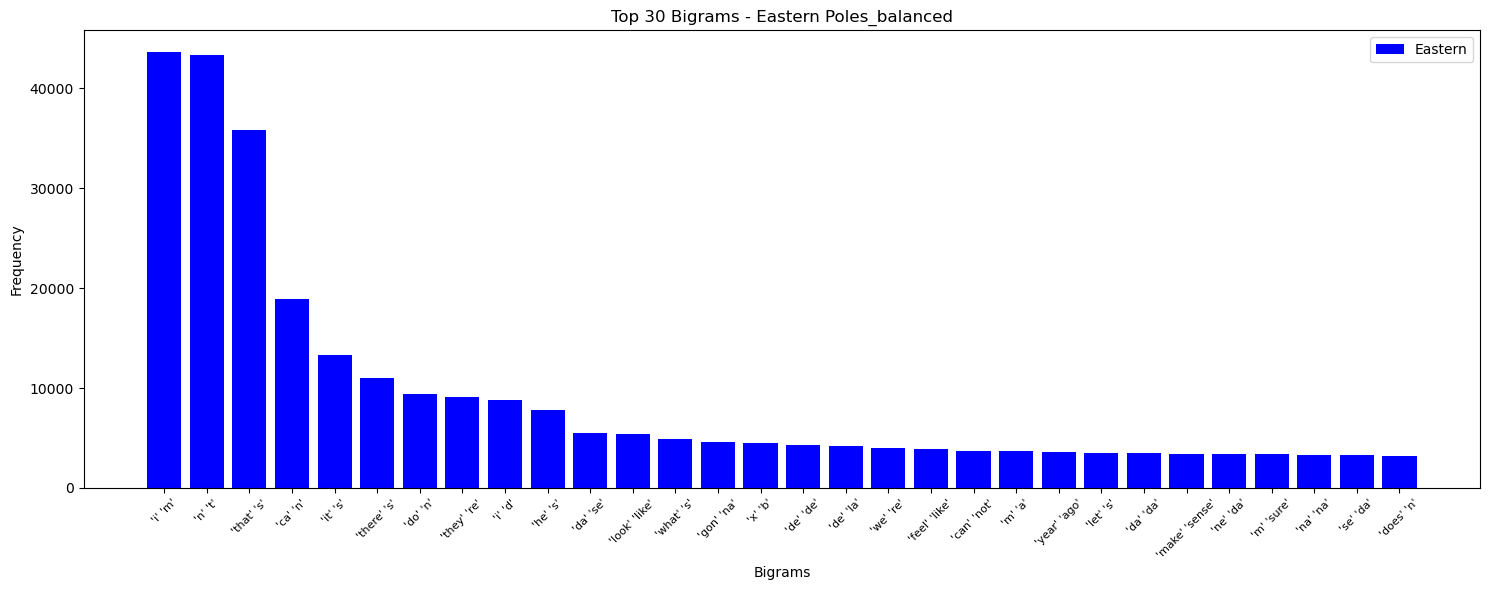

In [7]:
# Visualize the comparison for Eastern poles (bar chart)
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(top30_eastern_bigrams_balanced_str, [freq for _, freq in top30_eastern_bigrams_balanced], color='blue', label='Eastern')

# Set plot labels and title
ax.set_xlabel('Bigrams')
ax.set_ylabel('Frequency')
ax.set_title('Top 30 Bigrams - Eastern Poles_balanced')
ax.tick_params(axis='x', rotation=45, labelsize=8)

# Display legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

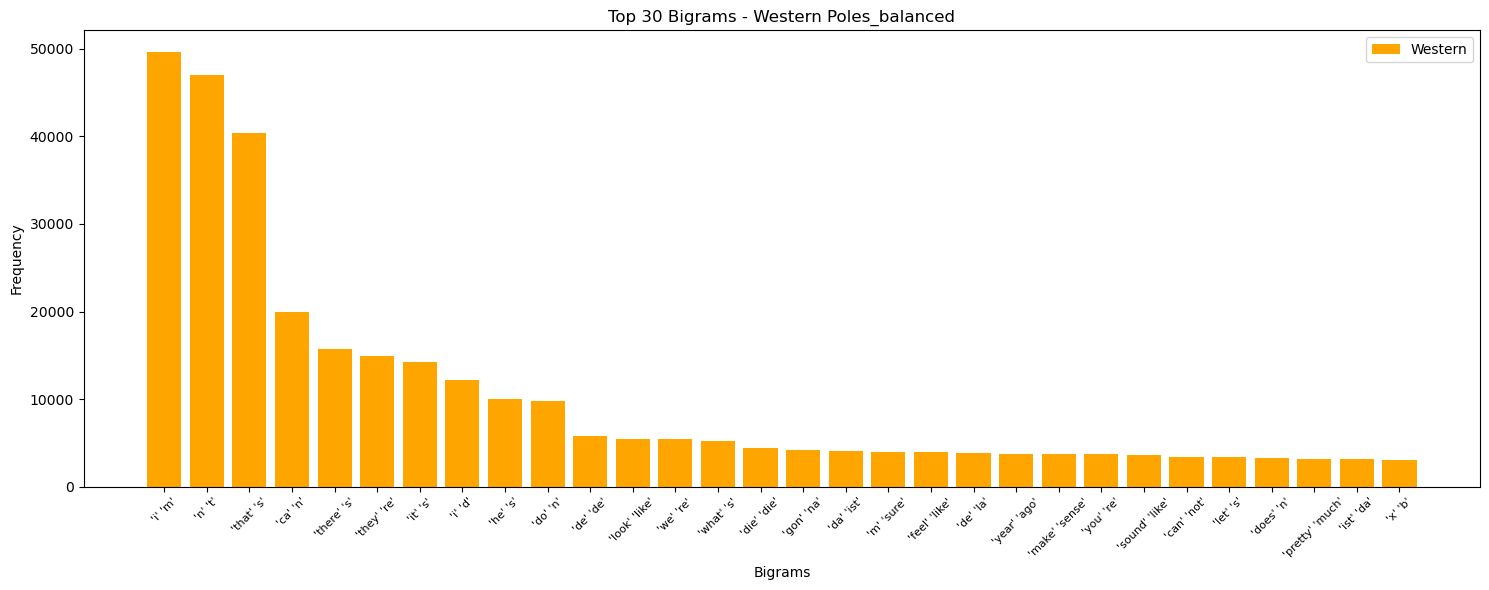

In [8]:
# Visualize the comparison for Western poles (bar chart)
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(top30_western_bigrams_balanced_str, [freq for _, freq in top30_western_bigrams_balanced], color='orange', label='Western')

# Set plot labels and title
ax.set_xlabel('Bigrams')
ax.set_ylabel('Frequency')
ax.set_title('Top 30 Bigrams - Western Poles_balanced')
ax.tick_params(axis='x', rotation=45, labelsize=8)

# Display legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
## Print the top 30 bi-grams for eastern and western users:
print('top30_eastern_bigrams: ')
print(top30_eastern_bigrams_balanced)
print('top30_western_bigrams: ')
print(top30_western_bigrams_balanced)

top30_eastern_bigrams: 
[(("'i'", "'m'"), 43630), (("'n'", "'t'"), 43301), (("'that'", "'s'"), 35863), (("'ca'", "'n'"), 18863), (("'it'", "'s'"), 13302), (("'there'", "'s'"), 10990), (("'do'", "'n'"), 9367), (("'they'", "'re'"), 9078), (("'i'", "'d'"), 8845), (("'he'", "'s'"), 7800), (("'da'", "'se'"), 5509), (("'look'", "'like'"), 5434), (("'what'", "'s'"), 4857), (("'gon'", "'na'"), 4633), (("'x'", "'b'"), 4516), (("'de'", "'de'"), 4307), (("'de'", "'la'"), 4228), (("'we'", "'re'"), 3972), (("'feel'", "'like'"), 3905), (("'can'", "'not'"), 3677), (("'m'", "'a'"), 3665), (("'year'", "'ago'"), 3622), (("'let'", "'s'"), 3532), (("'da'", "'da'"), 3469), (("'make'", "'sense'"), 3431), (("'ne'", "'da'"), 3418), (("'m'", "'sure'"), 3386), (("'na'", "'na'"), 3337), (("'se'", "'da'"), 3303), (("'does'", "'n'"), 3234)]
top30_western_bigrams: 
[(("'i'", "'m'"), 49645), (("'n'", "'t'"), 47065), (("'that'", "'s'"), 40349), (("'ca'", "'n'"), 19912), (("'there'", "'s'"), 15691), (("'they'", "'re'"

### Feature Extraction: 

In [10]:
class NgramFeatureExtractor:
    def __init__(self, n=2):
        self.n = n

    def create_ngram_features(self, words):
        ngram_vocab = ngrams(words, self.n)
        my_dict = dict([(ng, True) for ng in ngram_vocab])
        return my_dict

In [11]:
# Convert 'Poles' to a binary label (0 for Eastern, 1 for Western) for binary classification
label_mapping = {'Eastern': 0, 'Western': 1}
tokenized_nationality_balanced['label'] = tokenized_nationality_balanced['Poles'].map(label_mapping)
 
# Initialize lists to store results
results_balanced = []

### Running through Naive Bayes model for author classification

In [12]:
# Iterate through different N-gram sizes (bi-grams and tri-grams)
for n in [2, 3]:
    ngram_extractor_balanced = NgramFeatureExtractor(n)
    author_data_balanced = []

    # Iterate through rows in the DataFrame
    for index, row in tokenized_nationality_balanced.iterrows():
        words_balanced = word_tokenize(row['eng_tokens'])
        author_data_balanced.append((ngram_extractor_balanced.create_ngram_features(words_balanced), row['label']))

    # Split the data into training and testing sets
    train_set_balanced, test_set_balanced = train_test_split(author_data_balanced, test_size=0.2, random_state=42)

    # Train a Naive Bayes classifier
    classifier_balanced = NaiveBayesClassifier.train(train_set_balanced)

    # Evaluate the model on the test set
    predictions_balanced = [classifier_balanced.classify(features) for features, _ in test_set_balanced]
    true_labels_balanced = [label for _, label in test_set_balanced]

    # Calculate and print accuracy
    accuracy_balanced = accuracy_score(true_labels_balanced, predictions_balanced)
    print(str(n) + '-gram accuracy:', accuracy_balanced)

    # Classification Report
    report_balanced = classification_report(true_labels_balanced, predictions_balanced)
    print(f"{n}-gram Classification Report:\n{report_balanced}")

    # Store results for later analysis if needed
    results_balanced.append({'n': n, 'accuracy': accuracy_balanced, 'predictions': predictions_balanced, 'true_labels': true_labels_balanced})

2-gram accuracy: 0.6996283729196963
2-gram Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.39      0.56      3058
           1       0.63      1.00      0.77      3131

    accuracy                           0.70      6189
   macro avg       0.81      0.70      0.67      6189
weighted avg       0.81      0.70      0.67      6189

3-gram accuracy: 0.699143641945387
3-gram Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.39      0.56      3058
           1       0.63      1.00      0.77      3131

    accuracy                           0.70      6189
   macro avg       0.81      0.70      0.67      6189
weighted avg       0.81      0.70      0.67      6189



#### Hyperparameter tuning with smoothing:
Laplace (add-one) smoothing

In [13]:
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from nltk.probability import LaplaceProbDist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'eng_tokens' contains the tokenized text and 'label' contains the binary label
featuresets = [
    (FreqDist(word_tokenize(row['eng_tokens'])), row['label'])
    for _, row in tokenized_nationality_balanced.iterrows()
]

# Split the data into training and validation sets
train_set, val_set = train_test_split(featuresets, test_size=0.2, random_state=42)

# Initialize the Naive Bayes classifier with Laplace smoothing
classifier = NaiveBayesClassifier.train(train_set, estimator=LaplaceProbDist)

# Evaluate on validation set
val_predictions = [classifier.classify(features) for features, _ in val_set]
val_accuracy = accuracy_score([label for _, label in val_set], val_predictions)

print(f"Validation Accuracy: {val_accuracy}")


Validation Accuracy: 0.7140087251575375


Thus, 71.4% of the instances in the validation set were classified correctly by the NB trained model.

#### Cross validation: 
k-fold cross-validation and returns the accuracy for each fold

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# Assuming 'eng_tokens' contains the tokenized text and 'label' contains the binary label
X = tokenized_nationality_balanced['eng_tokens']
y = tokenized_nationality_balanced['label']

# Create a pipeline with CountVectorizer and Multinomial Naive Bayes
model = make_pipeline(CountVectorizer(), MultinomialNB())

# Perform 10-fold cross-validation
cross_val_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Accuracy:", cross_val_scores.mean())


Cross-Validation Scores: [0.87043619 0.88852989 0.82352941 0.82902392 0.86619263 0.7656755
 0.77343245 0.88332256 0.78862314 0.77731092]
Mean Accuracy: 0.8266076610835709


In [17]:
from sklearn.metrics import matthews_corrcoef
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef([label for _, label in val_set], val_predictions)

print(f'Validation Accuracy: {val_accuracy}')
print(f'Matthews Correlation Coefficient: {mcc}')

Validation Accuracy: 0.7140087251575375
Matthews Correlation Coefficient: 0.5167339808374946
